## **Eduardo Carrasco Vidal** <img src="img/logo.png" align="right" style="width: 120px;"/>

**Magister en Inteligencia Artificial, Universidad Adolfo Ibáñez.**

**Profesor:** Jorge Vásquez.
**Curso:** Aprendizaje Reforzado (Reinforcement Learning).

Enlace al repositorio del alumno en [GitHub](https://github.com/educarrascov/MIA_ReinforcementLearning) _@educarrascov_

![Python](https://img.shields.io/badge/python-%2314354C.svg) 

# Tarea 2: Multi-Armed Bandits and Reinforcement Learning.

A. Requerimientos: 
- Tarea individual, no trabajar en grupo.
- Entrega para el 28 de junio.
- Entregable es un PDF del resumen de la tarea, parte del su código y el gráfico solicitado.

B. Objetivo: Implementar multiarm bandits

C. Descripción:

- Vamos a usar “10-arm testbed” descrito en el libro del curso (Sutton, Section 2.3). Donde hay 10 palancas (_K=10 arms_), la recompensa promedio para cada palanca es _Ɲ(0,1)_ y cuando el agente tira la palanca _A_, se observa una recompensa con ruido _r ~ Ɲ(r(a),1)_, esto significa _r(a)+ Ɲ(0,1)_.
- Implementa una exploración Є-greedy. Plotear la recompensa esperada en el eje de las Y, y timesteps en el eje X para los siguientes valores Є:[0, 0.001, 0.01, 0.1, 1.0].
- Los resultados para cada valor de Є deben ser representados en diferentes líneas del mismo gráfico.
- Haz correr el algoritmo 20 veces para cada valor Є y toma el promedio de esos experimentos.
- Se computan las recompensas esperadas de la forma: σ𝑎 𝑟(𝑎)𝜋(𝑎).

## 1. Descripción del Sistema:

El problema Multi-Armed Bandits consiste en un número determinado _K_ de máquinas tragamonedas (_row of slot machines: "Bandits"_). En cada tiempo _t_ el jugador debe elegir una de las _K_ máquinas, la cual le devolverá una recompensa.
Como objetivo principal del sistema, se plantea maximizar la recompensa acumulada, encontrando la mejor máquina en el menor tiempo posible.

Dentro de los escenarios que el jugador puede obtener, se encuentran:

- Que una de las _K_ Máquinas esté dando muchos premios hacíendonos pasar como que es la mejor, pero no siendo la mejor.
- Por otra parte, una de las _K_ máquinas no dé premios justo en el instante que nosotros jugamos.

Todo lo anterior, crea un ambiente de inseguridad que trata de responder la pregunta ¿Es esta la mejor máquina para jugar? o ¿existe uno mejor?.

Lo anterior, se observa en el **dilema Explorar o Explotar**, lo cual se profundizará en las secciones precedentes.

## 2. Setup del Problema:

Habiendo descrito el problema en el punto anterior, objeto definir técnicamente lo que se requiere, se tiene la siguiente ecuación:

$Qt(a)=E[Rn|An=a]$

En esta ecuación $Qt(a)$ es la recompensa estimada de (Rn) cuando se elige la acción An del paso n.

Para desarrollar lo anterior, se desarrollará un modelo que cubra el valor verdadero (_media - promedio_) de cada acción usando distribución normal (Gaussiana).

### 2.1. Explotación:

De acuerdo a lo requerido en el enunciado, se utilizará un **Greedy Action**, de manera de tomar la acción que se piensa que traerá el mayor beneficio en cada paso (_timestep_). Como se describe en la siguiente ecuación:

$A_n=MAX_a(Q_n(a))$

Se puede observar que la expectación máxima de greedy es $A^*_n$, que simboliza la explotación del **dilema explorar-explotar**, como primera aproximación, hacer repetidamente permite maximizar nuestra recompensa.

### 2.2. Exploración:

Como fue presentado en el punto anterior, se tiene un algoritmo que permita obtener la explotación. Pero, de igual manera se requiere uno que efectúe la exploración del espacio de búsqueda para ejecutar las mejores acciones.

Para ejecutar el cálculo, necesitamos sólo 2 valores conocidos, la media y el número de pasos dados.

$m_n=m_{n-1}+\frac{R_n + m_{n-1}}{n}$

Como se observa en la ecuación, si se requiere calcular la media en el tiempo n, m_n, se puede efectuar con la media del tiempo anterior, $m_{n-1}$.

## 3. Implementación del Método ϵ-Greedy:

A diferencia del método greedy puro (explicado anteriormente), este introduce un ϵ que permite efectuar la exploración a modo de probabilidad.

Para efectuar la modelación, se definen las siguientes variables:

- `eps_bandit`: es la clase del experimento.
- `k` : es la cantdad de máquinas.
- `eps` : es la probabilidad (ruído) epsilon del modelo.
- `iters` : es el número de iteraciones.
- `mu` : es la recompensa que se ajusta para cada máquina, por default es N (0,1).

In [106]:
# pip install modules

In [107]:
import modules 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
%matplotlib inline

In [108]:
class eps_bandit:
    '''
    epsilon-greedy k-bandit problem
    
    Inputs
    =====================================================
    k: number of arms (int)
    eps: probability of random action 0 < eps < 1 (float)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0. 
        Set to "sequence" for the means to be ordered from 
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    '''
    
    def __init__(self, k, eps, iters, mu='random'):
        # Number of arms
        self.k = k
        # Search probability
        self.eps = eps
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)
        
        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages            
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)
        
    def pull(self):
        # Generate random number
        p = np.random.rand()
        if self.eps == 0 and self.n == 0:
            a = np.random.choice(self.k)
        elif p < self.eps:
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward)
            
        reward = np.random.normal(self.mu[a], 1)
        
        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Update total
        self.mean_reward = self.mean_reward + (
            reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (
            reward - self.k_reward[a]) / self.k_n[a]
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
            
    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)

### 3.1. Método de ϵ-Greedy - 1er modelo:

Se efectuará un modelado utilizando el método de ϵ-Greedy, con las siguientes características:

- `k` = 10 máquinas.
- `iters` = 3000 iteraciones.
- `episodes` = 20 experimentos.
- `eps_0_rewards` = recompensas con epsilon = 0 (greedy).
- `eps_001_rewards` = recompensas con epsilon = 0.001.
- `eps_01_rewards` = recompensas con epsilon = 0.01.
- `eps_1_rewards` = recompensas con epsilon = 0.1.
- `eps_10_rewards` = recompensas con epsilon = 1.0`

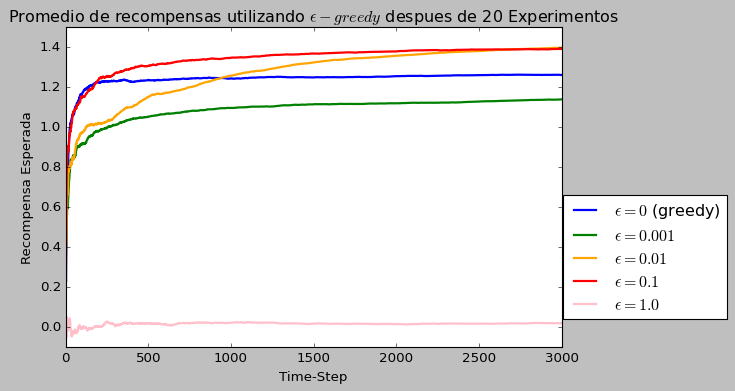

In [120]:
k = 10
iters = 3000

eps_0_rewards = np.zeros(iters)
eps_001_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)
eps_10_rewards = np.zeros(iters)

eps_0_selection = np.zeros(k)
eps_001_selection = np.zeros(k)
eps_01_selection = np.zeros(k)
eps_1_selection = np.zeros(k)
eps_10_selection = np.zeros(k)

episodes = 20
for i in range(episodes):
# Inicialización de las máquinas (bandits)
    eps_0 = eps_bandit(k, 0, iters)
    eps_001 = eps_bandit(k, 0.001, iters, eps_0.mu.copy())
    eps_01 = eps_bandit(k, 0.01, iters, eps_0.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, eps_0.mu.copy())
    eps_10 = eps_bandit(k, 1.0, iters, eps_0.mu.copy())
    
# Comenzar Experimentos
    eps_0.run()
    eps_001.run()
    eps_01.run()
    eps_1.run()
    eps_10.run()
    
# Actualizar recompensas:
    eps_0_rewards = eps_0_rewards + (
        eps_0.reward - eps_0_rewards) / (i + 1)
    eps_001_rewards = eps_001_rewards + (
        eps_001.reward - eps_001_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (
        eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    eps_10_rewards = eps_10_rewards + (
        eps_10.reward - eps_10_rewards) / (i + 1)
    
# Promedio de acciones efectuadas por experimento
    eps_0_selection = eps_0_selection + (
        eps_0.k_n - eps_0_selection) / (i + 1)
    eps_001_selection = eps_001_selection + (
        eps_001.k_n - eps_001_selection) / (i + 1)
    eps_01_selection = eps_01_selection + (
        eps_01.k_n - eps_01_selection) / (i + 1)
    eps_1_selection = eps_1_selection + (
        eps_1.k_n - eps_1_selection) / (i + 1)
    eps_10_selection = eps_10_selection + (
        eps_10.k_n - eps_10_selection) / (i + 1)
    
plt.figure(figsize=(8,5))
plt.style.use("classic")
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)", linewidth=2.0, color='blue')
plt.plot(eps_001_rewards, label="$\epsilon=0.001$", linewidth=2.0, color='green')
plt.plot(eps_01_rewards, label="$\epsilon=0.01$", linewidth=2.0, color='orange')
plt.plot(eps_1_rewards, label="$\epsilon=0.1$", linewidth=2.0, color='red')
plt.plot(eps_10_rewards, label="$\epsilon=1.0$", linewidth=2.0, color='pink')
plt.ylim(-0.1,1.50)
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.xlabel("Time-Step")
plt.ylabel("Recompensa Esperada")
plt.title("Promedio de recompensas utilizando $\epsilon-greedy$ despues de " + str(episodes) 
    + " Experimentos")
plt.show()

Como se observa en el gráfico, la función `eps_1_rewards`, que involucra un **epsilon de 0.1** es que la logra maximizar la recompensa.

### 3.2. Método de ϵ-Greedy - 2do modelo:

Con el objeto observar de mejor manera cuales acciones proveen la mejor recompensa, se puede setear _mu=sequence_, de manera de sequenciar las recompensas y permitiendo observar de mejor manera, cual es la función que genera el mayor beneficio

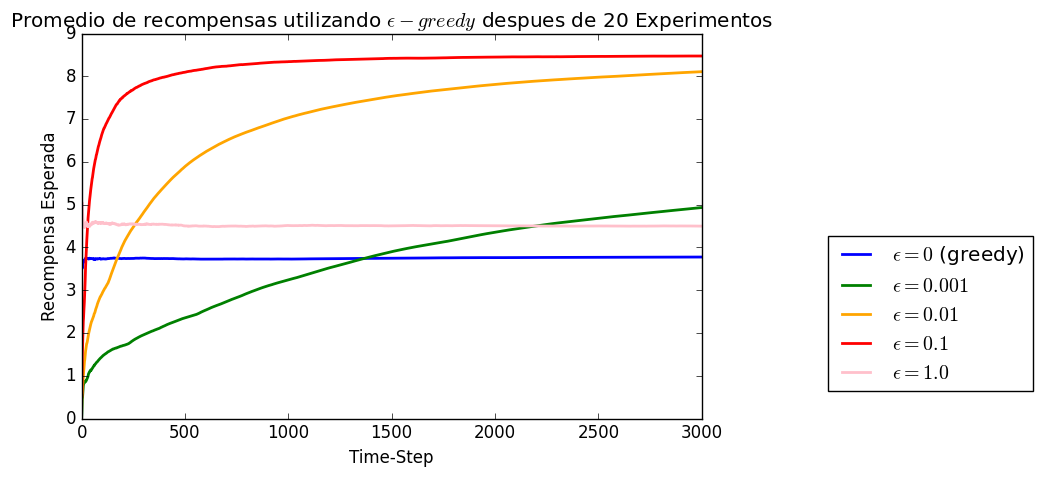

In [103]:
k = 10
iters = 3000

eps_0_rewards = np.zeros(iters)
eps_001_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)
eps_10_rewards = np.zeros(iters)

eps_0_selection = np.zeros(k)
eps_001_selection = np.zeros(k)
eps_01_selection = np.zeros(k)
eps_1_selection = np.zeros(k)
eps_10_selection = np.zeros(k)

episodes = 20
for i in range(episodes):
# Inicialización de las máquinas (bandits)
    eps_0 = eps_bandit(k, 0, iters, mu='sequence')
    eps_001 = eps_bandit(k, 0.001, iters, eps_0.mu.copy())
    eps_01 = eps_bandit(k, 0.01, iters, eps_0.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, eps_0.mu.copy())
    eps_10 = eps_bandit(k, 1.0, iters, eps_0.mu.copy())
    
# Comenzar Experimentos
    eps_0.run()
    eps_001.run()
    eps_01.run()
    eps_1.run()
    eps_10.run()
    
# Actualizar recompensas:
    eps_0_rewards = eps_0_rewards + (
        eps_0.reward - eps_0_rewards) / (i + 1)
    eps_001_rewards = eps_001_rewards + (
        eps_001.reward - eps_001_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (
        eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    eps_10_rewards = eps_10_rewards + (
        eps_10.reward - eps_10_rewards) / (i + 1)
    
# Promedio de acciones efectuadas por experimento
    eps_0_selection = eps_0_selection + (
        eps_0.k_n - eps_0_selection) / (i + 1)
    eps_001_selection = eps_001_selection + (
        eps_001.k_n - eps_001_selection) / (i + 1)
    eps_01_selection = eps_01_selection + (
        eps_01.k_n - eps_01_selection) / (i + 1)
    eps_1_selection = eps_1_selection + (
        eps_1.k_n - eps_1_selection) / (i + 1)
    eps_10_selection = eps_10_selection + (
        eps_10.k_n - eps_10_selection) / (i + 1)
    
plt.figure(figsize=(8,5))
plt.style.use("classic")
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)", linewidth=2.0, color='blue')
plt.plot(eps_001_rewards, label="$\epsilon=0.001$", linewidth=2.0, color='green')
plt.plot(eps_01_rewards, label="$\epsilon=0.01$", linewidth=2.0, color='orange')
plt.plot(eps_1_rewards, label="$\epsilon=0.1$", linewidth=2.0, color='red')
plt.plot(eps_10_rewards, label="$\epsilon=1.0$", linewidth=2.0, color='pink')
plt.ylim(0,9)
plt.legend(bbox_to_anchor=(1.55, 0.5))
plt.xlabel("Time-Step")
plt.ylabel("Recompensa Esperada")
plt.title("Promedio de recompensas utilizando $\epsilon-greedy$ despues de " + str(episodes) 
    + " Experimentos")
plt.show()

Como se observa, de igual manera se obtuvo el `eps_1_rewards`, de epsilon = 0.1, para lo cual, se mostrará un cuadro que represente el número de acciones efectuadas por cada acción.

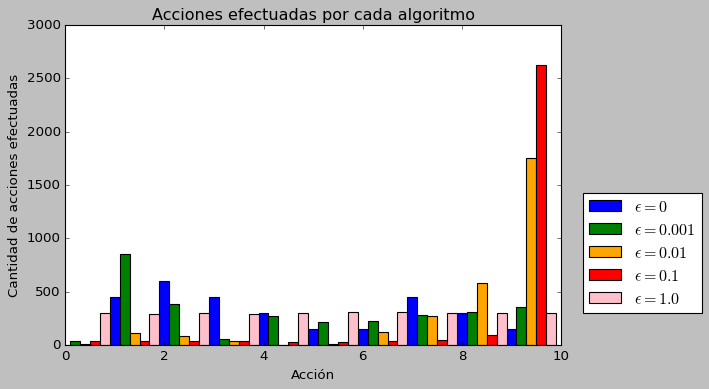

Porcentaje de acciones seleccionadas:


,a = 0,a = 1,a = 2,a = 3,a = 4,a = 5,a = 6,a = 7,a = 8,a = 9
$\epsilon=0$,0.013333,15.001667,19.985000,15.000000,10.000000,5.000000,5.000000,15.000000,10.000000,5.000000
$\epsilon=0.001$,1.358333,28.523333,12.948333,1.731667,8.996667,7.273333,7.515000,9.318333,10.320000,12.015000
$\epsilon=0.01$,0.306667,3.773333,2.778333,1.363333,0.110000,0.330000,4.071667,9.188333,19.528333,58.550000
$\epsilon=0.1$,1.110000,1.240000,1.098333,1.120000,1.025000,1.066667,1.196667,1.501667,3.108333,87.533333
$\epsilon=1.0$,10.090000,9.821667,10.011667,9.750000,9.898333,10.270000,10.191667,10.070000,9.851667,10.045000


In [93]:
bins = np.linspace(0, k-1, k)

plt.figure(figsize=(8,5))
plt.bar(bins, eps_0_selection, 
        width = 0.20, color='blue', 
        label="$\epsilon=0$")
plt.bar(bins+0.20, eps_001_selection,
        width=0.20, color='green', 
        label="$\epsilon=0.001$")
plt.bar(bins+0.40, eps_01_selection,
        width=0.20, color='orange', 
        label="$\epsilon=0.01$")
plt.bar(bins+0.60, eps_1_selection, 
        width=0.20, color='red',
        label="$\epsilon=0.1$")
plt.bar(bins+0.80, eps_10_selection, 
        width=0.20, color='pink',
        label="$\epsilon=1.0$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlim([0,k])
plt.title("Acciones efectuadas por cada algoritmo")
plt.xlabel("Acción")
plt.ylabel("Cantidad de acciones efectuadas")
plt.show()

opt_per = np.array([eps_0_selection, eps_001_selection, eps_01_selection,
                   eps_1_selection, eps_10_selection]) / iters * 100
df = pd.DataFrame(opt_per, index=['$\epsilon=0$', '$\epsilon=0.001$', 
    '$\epsilon=0.01$', '$\epsilon=0.1$', '$\epsilon=1.0$'],
                 columns=["a = " + str(x) for x in range(0, k)])
print("Porcentaje de acciones seleccionadas:")
df

Si observamos la selección promedio de los algoritmos, podemos ver por qué el mayor valor de epsilon = 0.1 lo hace mejor, obteniendo el valor optimo el 87% de las veces.

## 4. Implementación del Método ϵ-Decay:

La estrategia ϵ-greedy presentado en el punto 3, tiene una debilidad obvia al incluir continuamente un ruido (probabilidad), sin importar cuantos ejemplos se observen. 
Como se señala, existe una forma de determinar la solución optima a explotar y reducir la probabilidad de exploración en cada paso.
Para ello se utiliza _ϵ_ como una función del número de steps _n_.

$ϵ(n)=\frac{1}{1 + nß}$

Donde ß representa un factor escalar (tasa) y permitir al algoritmo un tiempo de exploración, $1 + nß$ permite que no sea definido como infinito.
Dado esto, se pueden definir las siguientes variables:

- `eps_decay_bandi`: es la nueva clase del experimento, esta vez con ϵ-Decay.
- `k` : es la cantdad de máquinas.
- `eps` : es la probabilidad (ruído) epsilon del modelo.
- `iters` : es el número de iteraciones.
- `mu` : es la recompensa que se ajusta para cada máquina, por default es N (0,1).

In [94]:
class eps_decay_bandit:
    '''
    epsilon-decay k-bandit problem
    
    Inputs
    =====================================================
    k: number of arms (int)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0. 
        Set to "sequence" for the means to be ordered from 
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    '''
    
    def __init__(self, k, iters, mu='random'):
        # Number of arms
        self.k = k
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)
        
        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages            
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)
        
    def pull(self):
        # Generate random number
        p = np.random.rand()
        if p < 1 / (1 + self.n / self.k):
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward)
            
        reward = np.random.normal(self.mu[a], 1)
        
        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Update total
        self.mean_reward = self.mean_reward + (
            reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (
            reward - self.k_reward[a]) / self.k_n[a]
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
            
    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)

### 4.1. Método de ϵ-Decay:

Se efectuará un modelado utilizando el método de ϵ-Decay, se seleccionó el epsilon que obtuvo mayores recompensas en el modelado anterior, con las siguientes características:

- `k` = 10 máquinas.
- `iters` = 3000 iteraciones.
- `episodes` = 20 experimentos.
- `eps_1_rewards` = recompensas con epsilon = 0.1.
- `eps_decay_rewards` = recompensas con modelo ϵ-Decay.

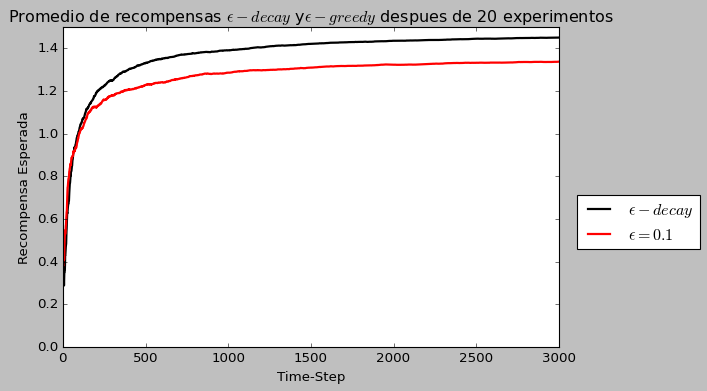

In [105]:
k = 10
iters = 3000
eps_decay_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)
episodes = 20
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_decay = eps_decay_bandit(k, iters)
    eps_1 = eps_bandit(k, 0.1, iters, eps_decay.mu.copy())
    
    # Run experiments
    eps_decay.run()
    eps_1.run()
    
    # Update long-term averages
    eps_decay_rewards = eps_decay_rewards + (
        eps_decay.reward - eps_decay_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    
plt.figure(figsize=(8,5))
plt.plot(eps_decay_rewards, label="$\epsilon-decay$", linewidth=2.0, color='black')
plt.plot(eps_1_rewards, label="$\epsilon=0.1$", linewidth=2.0, color='red')
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.ylim(0,1.5)
plt.xlabel("Time-Step")
plt.ylabel("Recompensa Esperada")
plt.title("Promedio de recompensas $\epsilon-decay$ y" + 
    "$\epsilon-greedy$ despues de " 
    + str(episodes) + " experimentos")
plt.show()

Se puede observar que utilizar el algoritmo ϵ-Decay, permite optimizar aún el experimento.

## 5. Comentarios Finales:

En base a los resultados del experimento, en el primer modelo **ϵ-Greedy** podemos señalar que esta estrategia permite inicialmente maximizar la recompensa ya que jugará preferentemente con la máquina que ha ofrecido la mayor recompensa hasta ese momento.

Con respecto al **ϵ-Decay**, esta es más eficiente que el **método greedy** puesto que al seleccionar una máquina inicialmente al azar y, a medida que avanzan los experimentos, cada vez de una forma más avariciosa permite obtener mayores recompensas. Esto debido a que, una vez que se conoce cual es la mejor máquina ya no es necesario **explorar** en busca del mejor.

Con lo anterior, hemos visto el impacto de balancear correctamente la **exploración y la explotación** de las acciones con un mayor valor estimado y el uso del conocimiento a priori para obtener unas estimaciones mejores y más rápidas de $Q_a^*$ de cada acción.

Por último, cabe señalar que existe una diversidad de modelos para resolver el problema del Multi-Armed Bandit, entre los cuales existen:
- UCB1.
- Softmax.
- Optimistic Inicial Values.
- Test A/B.
- Pursuit Algorithm.
- CP-UCB.
- UCB-V.
- MOSS.
- EXP3.

Los cuales presentan diferentes métodos para encontrar la optimalidad.

## 6. Referencias:
[1]. Wong, Anson (2017) Solving the Multi-Armed Bandit Problem. Towards Data Science. [En línea]. Disponible en: https://towardsdatascience.com/solving-the-multi-armed-bandit-problem-b72de40db97c, [Acceso el 27 de junio de 2022].

[2]. Data Incubator (2016) Multi-Armed Bandits. [En línea]. Disponible en: https://www.thedataincubator.com/blog/2016/07/25/multi-armed-bandits-2/, [Acceso el 27 de junio de 2022].

[3]. Guinea, Álvaro [P.G. González Ana] (2016) Introducción al Aprendizaje de Refuerzo, Problema del Bandido multibrazo. Tesis para obtener el grado de Ingeniero Informático. Universidad Autónoma de Madrid [En línea]. Disponible en: https://repositorio.uam.es/bitstream/handle/10486/675554/Guinea_Julia_Alvaro_tfg.pdf?sequence=1&isAllowed=y, [Acceso el 27 de junio de 2022].

[4]. Hubbs, Christian (2019) Multi-Armed Bandits and Reinforcement Learning. Towards Data Science. [En línea]. Disponible en: https://towardsdatascience.com/multi-armed-bandits-and-reinforcement-learning-dc9001dcb8da, [Acceso el 27 de junio de 2022].

[5]. Rodríguez, Daniel (2021) Epsilon-Greedy para el Bandido Multibrazo (Multi-Armed Bandit). Analytics Lane. [En línea]. Disponible en: https://www.analyticslane.com/2021/02/26/epsilon-gready-para-el-bandido-multibrazo-multi-armed-bandit/, [Acceso el 27 de junio de 2022].

[6]. Rodríguez, Daniel (2021) Epsilon-Greedy con decaimiento para un problema Bandido Multibrazo (Multi-Armed Bandit). Analytics Lane. [En línea]. Disponible en: https://www.analyticslane.com/2021/03/05/epsilon-greedy-con-decaimiento-para-un-problema-bandido-multibrazo-multi-armed-bandit/, [Acceso el 27 de junio de 2022].